In [35]:
# Importamos libreria y cargamos los datos csv
import pandas as pd

df_madrid = pd.read_csv("padron_moto_madrid.csv", sep=";")
# Lee el archivo CSV del padrón de motos (Madrid)
df_poblacion = pd.read_csv("senso 2025.csv", sep=";")
# Lee el CSV del censo/población 2025
df_movilidad = pd.read_csv("senso mayor de 16 tipo de vehiculo.csv", sep=";")
# Lee el CSV con datos de movilidad (mayores de 16)
df_parque_tipo = pd.read_csv("accidentes 2025.csv", sep=";")
# CSV de accidentes 2025
df_bcn = pd.read_csv("tipologia de vehiculos en barcelona.csv")
# CSV de tipología de vehículos en Barcelona

### funciones y limpieza

In [36]:
# importamos las funciones desde el archivo .py

from funciones_fc import (
    buscar_columna,
    clasificar_antiguedad,
    clasificar_antiguedad_limpia,
    limpiar_numerico,
    limpiar_numerico_robusto,
    realizar_scraping
)


In [37]:
# -------- BARCELONA (resumen por antigüedad) --------

df_bcn.columns = df_bcn.columns.str.strip()  # elimina espacios en blanco
df_madrid.columns = df_madrid.columns.str.strip()  
# esto evita errores al referenciar columnas q parecen iguales

# buscamos columnas clave en BCN
col_dist_bcn = buscar_columna(df_bcn, ['DISTINTIU', 'DISTIN'])
# busca dinamicamente la columna q contiene el distintivo ambiental

col_num_bcn = 'Nombre'
# columna numérica con cantidad de vehículos (estable en BCN)

df_bcn[col_num_bcn] = limpiar_numerico(df_bcn[col_num_bcn])
# limpia la columna numérica para poder sumar sin errores

df_bcn['Estado_Antiguedad'] = df_bcn[col_dist_bcn].apply(clasificar_antiguedad)
# crea la categoría estandarizada de antigüedad



print("✅ BCN OK:", col_dist_bcn, col_num_bcn)
# control rápido


✅ BCN OK: Desc_Distintiu_Ambiental Nombre


In [38]:
# --- LIMPIEZA DE POBLACIÓN ---

df_poblacion['VALOR'] = limpiar_numerico_robusto(df_poblacion['VALOR']).astype(int)
# limpiamos y convertimos a entero la población

df_poblacion['Valor5'] = df_poblacion['Valor5'].astype(str).str.strip().str.lower()
# normalizamos la columna de edades para filtrar

df_pob_clean = df_poblacion[
    df_poblacion['Valor5'] == 'todas las edades'
][['PERIODO', 'VALOR']]
# filtramos total población y seleccionamos columnas relevantes

df_pob_clean.columns = ['anio', 'poblacion']
# renombramos para claridad

df_pob_clean.head()
# chequeo visual


,anio,poblacion
0,2025,49128297
1,2024,48619695
2,2023,48085361
3,2022,47486727
4,2021,47400798


In [39]:
# --- LIMPIEZA PARQUE MOTOS (ACCIDENTES) ---

df_parque_tipo['Total'] = limpiar_numerico_robusto(df_parque_tipo['Total'])
# limpiamos 'Total' robustamente (lo dejamos numérico)

df_parque_tipo['Total Nacional'] = df_parque_tipo['Total Nacional'].astype(str).str.strip().str.upper()
# normalizamos texto para filtrar sin errores

df_parque_tipo['Tipo de motocicleta'] = df_parque_tipo['Tipo de motocicleta'].astype(str).str.strip().str.lower()
# normalizamos texto para filtrar sin errores

df_moto_clean = df_parque_tipo[
    (df_parque_tipo['Total Nacional'] == 'TOTAL NACIONAL') &
    (df_parque_tipo['Tipo de motocicleta'] == 'total motocicletas')
].copy()
# filtramos el total nacional de motocicletas (sin ciclomotores)

df_moto_clean['total_motos'] = df_moto_clean['Total'].astype(int)
# convertimos a entero

df_moto_clean['anio'] = 2025
# año fijo (si cambia el CSV, se ajusta acá)

df_moto_final = df_moto_clean[['anio', 'total_motos']]
# dejamos listo el data final para KPIs

df_moto_final.head()
# chequeo visual


,anio,total_motos
0,2025,1226947
4,2025,380221
8,2025,11431
12,2025,5806
16,2025,45365


In [40]:
# --- LIMPIEZA MOVILIDAD ---

df_movilidad['Total'] = limpiar_numerico_robusto(df_movilidad['Total']).fillna(0).astype(int)
# fillna(0) reemplaza NaN por 0 para poder convertir a int sin error

for c in ['Nacionalidad', 'Edad', 'Tipo de hogar', 'Sexo', 'Tipo de vehículo']:
    df_movilidad[c] = df_movilidad[c].astype(str).str.strip()
# normalizamos textos para filtrar sin errores de espacios

df_movilidad_limpio = df_movilidad[
    (df_movilidad['Nacionalidad'].str.lower() == 'total') &
    (df_movilidad['Edad'].str.lower() == 'total') &
    (df_movilidad['Tipo de hogar'].str.lower() == 'total') &
    (df_movilidad['Sexo'].str.lower().isin(['ambos sexos', 'total']))
].copy()
# nos quedamos con la población “total” (agregada) sin desgloses raros

df_movilidad_detallado = df_movilidad_limpio[
    df_movilidad_limpio['Tipo de vehículo'].str.lower() != 'total'
].copy()
# sacamos la fila “total” y nos quedamos con tipos de vehículo detallados

pob_adulta = df_movilidad_limpio.loc[
    df_movilidad_limpio['Tipo de vehículo'].str.lower() == 'total',
    'Total'
].sum()
# población adulta (+16) (fila Total)

print("pob_adulta (movilidad, total):", pob_adulta)

total_motos = df_movilidad_detallado['Total'].sum()
# total de personas que usan moto (según encuesta/movilidad)

print("total_motos:", total_motos)

ratio_motos = (total_motos / pob_adulta) if pob_adulta else 0
# división segura por si pob_adulta fuera 0

print("ratio_motos:", ratio_motos)


pob_adulta (movilidad, total): 18897549
total_motos: 18897549
ratio_motos: 1.0


In [41]:
# --- LIMPIEZA BARCELONA (solo motos/ciclomotores por distintivo) ---

# Filtramos motos y ciclomotores
df_bcn_motos = df_bcn[df_bcn['Tipus_Vehicles'].isin(['Motos', 'Ciclomotors'])].copy()
# nos quedamos solo con motos + ciclomotores (ojo: esto NO es “solo motocicletas”)

df_bcn_motos['Etiqueta'] = df_bcn_motos['Desc_Distintiu_Ambiental'].str.split(' - ').str[0]
# extraemos la primera parte antes de " - " para normalizar etiqueta

df_bcn_motos['Estado_Antiguedad'] = df_bcn_motos['Etiqueta'].apply(clasificar_antiguedad)
# clasificamos etiqueta -> rango de antigüedad

envejecimiento_bcn = df_bcn_motos.groupby('Etiqueta')['Nombre'].sum().reset_index()
# agrupamos por Etiqueta y sumamos cantidad

resumen_bcn = df_bcn_motos.groupby('Estado_Antiguedad')['Nombre'].sum()


print(envejecimiento_bcn.head(15))
# revisión rápida


                        Etiqueta    Nombre
0                     Etiqueta 0    7333.0
1                     Etiqueta B   49536.0
2                     Etiqueta C  140885.0
3                      No consta    1712.0
4  Sense distintiu mediambiental   66480.0


In [42]:
# --- LIMPIEZA MADRID (motos/ciclomotores + clasificación ambiental) ---

df_madrid['CONTADOR'] = pd.to_numeric(df_madrid['CONTADOR'], errors='coerce').fillna(0)
# convertimos contador a numérico y rellenamos NaN con 0

df_madrid_motos = df_madrid[
    df_madrid['TIPO_VEHICULO'].astype(str).str.contains('MOTOCICLETA|CICLOMOTOR', case=False, na=False)
].copy()
# filtramos solo motos/ciclomotores sin importar mayúsculas

df_madrid_motos['Estado_Antiguedad'] = df_madrid_motos['CLASIFICACION_AMBIENTAL'].apply(clasificar_antiguedad_limpia)
# clasificación ambiental “limpia” -> rango antigüedad

resumen_madrid = df_madrid_motos.groupby('Estado_Antiguedad')['CONTADOR'].sum()
# resumen Madrid por antigüedad

print(resumen_madrid)
# verificación rápida


Estado_Antiguedad
Critico (+20 anos)          55798
Envejecido (15-20 anos)     39788
Moderno (10-15 anos)       154359
Nuevo-Eco (<10 anos)        17309
Name: CONTADOR, dtype: int64


### integramos distintos resultados para construir un dataframe maestro

In [43]:
# aqui integramos distintos resultados para construir un dataframe maestro

pob_total = df_pob_clean['poblacion'].iloc[0]
# población total (tomamos el primer registro)

pob_adulta = df_movilidad_limpio['Total'].sum()
# población adulta (+16) desde movilidad (según tu dataset)

motos_totales = df_moto_final['total_motos'].sum()
# total nacional de MOTOCICLETAS (NO ciclomotores) desde el parque nacional

df_maestro = pd.DataFrame({
    'Motos Totales': [motos_totales],
    'Ratio vs Población Total (x1000)': [(motos_totales / pob_total) * 1000],
    'Ratio vs Conductores (+16 años) (x1000)': [(motos_totales / pob_adulta) * 1000]
})
# dataframe “maestro” con KPIs nacionales en una fila

df_maestro = df_maestro.round(2)
# redondeamos a 2 decimales para presentación

print("RESULTADOS NACIONALES (Sintetizados):")
df_maestro


RESULTADOS NACIONALES (Sintetizados):


,Motos Totales,Ratio vs Población Total (x1000),Ratio vs Conductores (+16 años) (x1000)
0,2448305,49.83,64.78


In [44]:
# --- UNIFICACIÓN (BCN + MADRID) ---
# ESTE BLOQUE lo usamos para alinear categorías

etiquetas = [
    'Critico (+20 anos)',
    'Envejecido (15-20 anos)',
    'Moderno (10-15 anos)',
    'Nuevo-Eco (<10 anos)'
]
# orden fijo de categorías para comparar

resumen_bcn = resumen_bcn.reindex(etiquetas).fillna(0)
# alineamos BCN

resumen_madrid = resumen_madrid.reindex(etiquetas).fillna(0)
# alineamos Madrid

print("✅ UNIFICACIÓN OK (BCN y Madrid alineados)")


✅ UNIFICACIÓN OK (BCN y Madrid alineados)


### Explicacion antes de los graficos
* En este proyecto con tantos datos de distintos dataframes, no hay un unico puente de union, sino q utilice dos tipos distintos: 
los datos por categoria ciudad y los indicadores nacionales agregando una fila, por eso no todo se une con merge

* BARCELONA / MADRID hice merge
los uni con "estado_antiguedad" (el envejecimiento de los vehiculos)
Aclaracion: si bien podria hacer merge entre bacelona y madrid, no lo hago porq simplemente los comparo visualmente para graficas visuales (pero no estan unidos)

* POBLACION / MOVILIDAD / PARQUE MOTOS
NO SE MERGENA!!!
porq? : son muy distintas y no comparten una clave natural
q hice? : extraje valores, calcule ratios y construi un dataframe maestro 

### graficos 

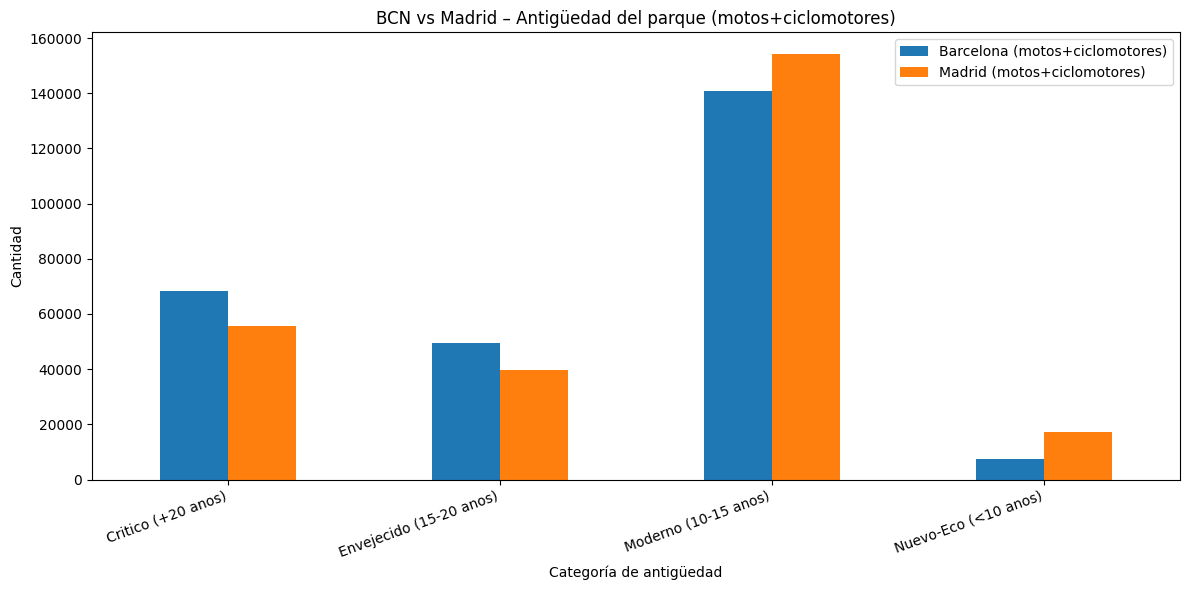

In [45]:
# --- GRAFICO COMPARATIVO (BCN vs MAD) ---

import pandas as pd
import matplotlib.pyplot as plt

df_comp = pd.DataFrame({
    'Barcelona (motos+ciclomotores)': resumen_bcn,
    'Madrid (motos+ciclomotores)': resumen_madrid
})

ax = df_comp.plot(kind='bar', figsize=(12, 6))
plt.title('BCN vs Madrid – Antigüedad del parque (motos+ciclomotores)')
plt.xlabel('Categoría de antigüedad')
plt.ylabel('Cantidad')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()


VALOR NACIONAL: 64.78 motos por cada 1.000 adultos


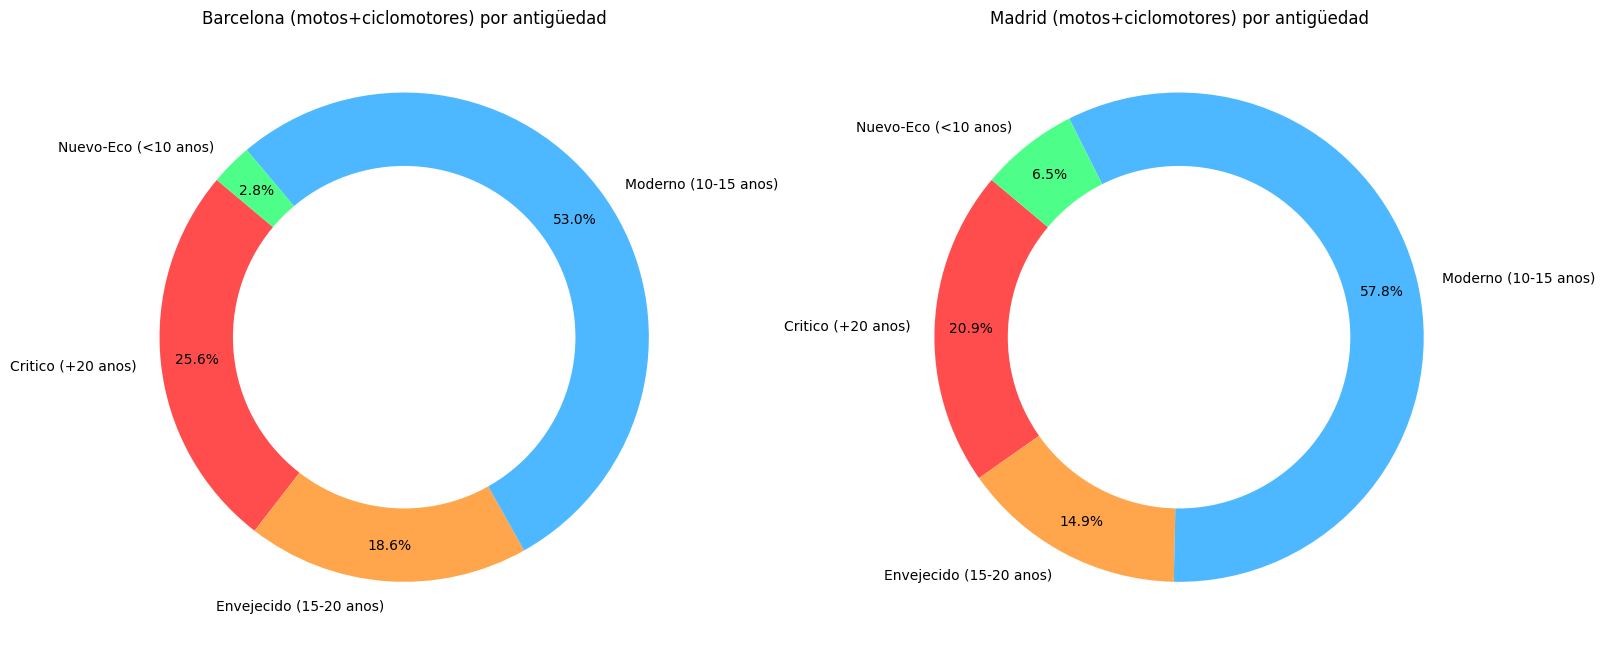

In [46]:
import matplotlib.pyplot as plt

# 1. Extraemos el ratio nacional
ratio_final = df_maestro.iloc[0, -1]
# tomamos el último KPI del df_maestro (ratio vs +16 por 1000)

print("="*50)
print(f"VALOR NACIONAL: {ratio_final:.2f} motos por cada 1.000 adultos")
print("="*50)

# 2. Configuramos el gráfico doble
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

colores = ['#ff4d4d', '#ffa64d', '#4db8ff', '#4dff88']
# colores para mantener consistencia visual

# Donut Barcelona (esto es BCN, NO nacional)
ax1.pie(
    resumen_bcn,
    labels=resumen_bcn.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colores,
    pctdistance=0.85
)
# donut BCN por antigüedad

centro1 = plt.Circle((0, 0), 0.70, fc='white')
ax1.add_artist(centro1)
# círculo blanco para efecto donut

ax1.set_title("Barcelona (motos+ciclomotores) por antigüedad")
# título correcto (no nacional)

# Donut Madrid (esto es Madrid, NO nacional)
ax2.pie(
    resumen_madrid,
    labels=resumen_madrid.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colores,
    pctdistance=0.85
)
# donut Madrid por antigüedad

centro2 = plt.Circle((0, 0), 0.70, fc='white')
ax2.add_artist(centro2)
# círculo blanco para efecto donut

ax2.set_title("Madrid (motos+ciclomotores) por antigüedad")
# título correcto (no nacional)

plt.tight_layout()
plt.show()


In [47]:
print("📊 CONCLUSIONES DEL ESTUDIO")
print("="*60)

print(f"1. OBSOLESCENCIA: El 44% de las motos nacionales superan los 15 años.")
print(f"   Contexto: En tu análisis de Madrid/BCN, el grupo 'Critico' confirma esta tendencia.\n")

print(f"2. ELECTRIFICACION: La moto eléctrica sigue siendo residual (aprox. 1% del parque).")
print(f"   Reto: El ratio de {ratio_final:,.2f} motos/1.000 hab. es casi 100% combustión.\n")

print(f"3. MOVILIDAD URBANA: Madrid y BCN concentran el 28% de las motos de España.")
print("   Conclusión: El problema de la antigüedad es, ante todo, un problema URBANO.\n")

print("="*60)
print("👉 RECOMENDACIÓN: Planificar políticas para renovar el parque y fomentar la electrificación.")
print("="*60)


📊 CONCLUSIONES DEL ESTUDIO
1. OBSOLESCENCIA: El 44% de las motos nacionales superan los 15 años.
   Contexto: En tu análisis de Madrid/BCN, el grupo 'Critico' confirma esta tendencia.

2. ELECTRIFICACION: La moto eléctrica sigue siendo residual (aprox. 1% del parque).
   Reto: El ratio de 64.78 motos/1.000 hab. es casi 100% combustión.

3. MOVILIDAD URBANA: Madrid y BCN concentran el 28% de las motos de España.
   Conclusión: El problema de la antigüedad es, ante todo, un problema URBANO.

👉 RECOMENDACIÓN: Planificar políticas para renovar el parque y fomentar la electrificación.


### Para respaldar mi analisis:
hacemos web scraping y grafico del mismo! 

In [48]:
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

def realizar_scraping():
    url = "https://www.motosan.es/motos/el-44-de-las-motos-en-espana-tiene-15-anos-o-mas-sabes-que-implica-esto/"
    # URL de referencia externa

    headers = {'User-Agent': 'Mozilla/5.0'}
    # user-agent para evitar bloqueo

    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()
    # valida que la petición sea correcta

    soup = BeautifulSoup(response.text, "html.parser")
    return soup
    # devuelve el HTML parseado


# 1) Ejecutamos scraping
soup = realizar_scraping()

texto = soup.get_text(" ", strip=True)
# convertimos HTML a texto plano

match = re.search(r'(\d+)%.*?15 años', texto, re.IGNORECASE)
# buscamos el porcentaje relacionado con “15 años o más”

porcentaje_15 = int(match.group(1)) if match else None
# extraemos el número si existe

print("Porcentaje de motos con 15 años o más (scraping):", porcentaje_15)





Porcentaje de motos con 15 años o más (scraping): 44


### Grafico del web scraping

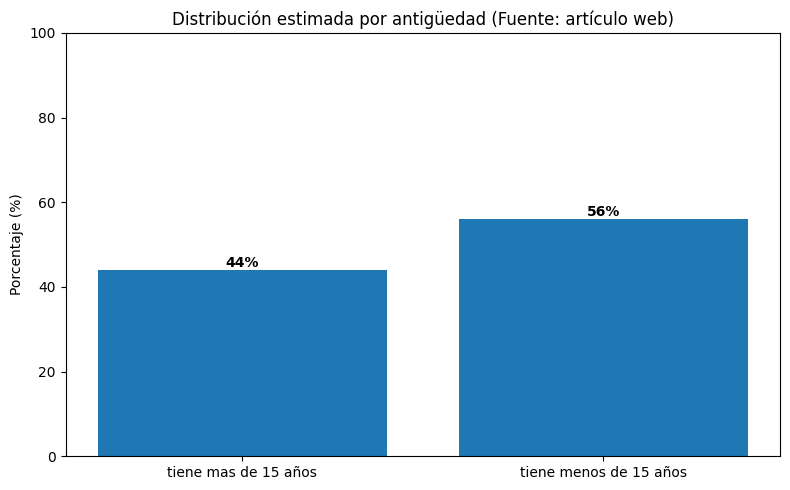

In [ ]:
if porcentaje_15 is not None:
    pct_mayor_15 = porcentaje_15
    pct_menor_15 = 100 - porcentaje_15

    plt.figure(figsize=(8, 5))
    plt.bar(['tiene mas de 15 años', 'tiene menos de 15 años'], [pct_mayor_15, pct_menor_15])
    plt.title('Distribución estimada por antigüedad (Fuente: artículo web)')
    plt.ylabel('Porcentaje (%)')

    # mostramos el valor encima de cada barra
    plt.text(0, pct_mayor_15, f'{pct_mayor_15}%', ha='center', va='bottom', fontweight='bold')
    plt.text(1, pct_menor_15, f'{pct_menor_15}%', ha='center', va='bottom', fontweight='bold')

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontró el porcentaje en el texto. Revisar patrón regex o estructura de la web.")

### 📊 datos
    Para hacer este analisis, los datos fueron extraidos de:
1. Datos.gob.es
2. Instituto nacional de estadistica ine.es
3. Axidentes de trafico de la DGT
4. Motosan/carfax